### Predicting individual differences from fMRI data

We will use the data from the Consortium for Neuropsychiatric Phenomics ([Poldrack et al., 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5139672/)) to examine prediction of individual differences from fMRI data.

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import os
from pathlib import Path
import nilearn
import sklearn
from nilearn.maskers import NiftiMasker
from sklearn.svm import SVC, SVR
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import RidgeCV, SGDClassifier, SGDRegressor
from scipy.stats import ks_2samp
from nilearn.plotting import plot_stat_map
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import einops
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestRegressor
from prediction_utils import (
    contrast_dict,
    add_pheno_var,
    get_data
)

device = 'mps'

### Load the data

In [3]:
basedir = Path('/Users/poldrack/data_unsynced/CNP')
output_dir = basedir / 'output'
if not output_dir.exists():
    output_dir.mkdir()


task = 'pamret'
contrast = 'All'
pheno_var = 'age'

data, metadata_df, data_img = get_data(basedir, task, contrast, pheno_var,
                             patientgroups = ['SCHZ', 'BIPOLAR', 'ADHD'],
                             smoothing_fwhm=4)

### Continuous prediction is tricky

First let's generate a y variable that we know to be correlated with the fMRI data, and make sure that we can predict it.  We will use a Weibull distribution to generate y values that are slightly skewed, like those often seen in real data.



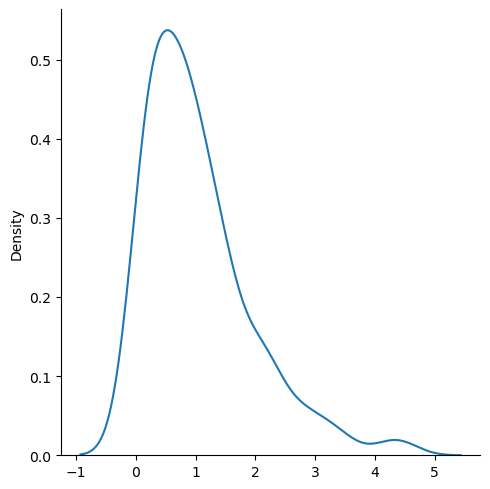

In [4]:
def make_simulated_y(data, snr=0, weib_param=1.1, seed=None):
    rng = np.random.RandomState(seed)
    weights = np.random.randn(data.shape[1])
    y_sim = data.dot(weights) * snr + rng.weibull(weib_param, size=data.shape[0])
    return y_sim

y_sim = make_simulated_y(data, snr=0, seed=1234)
sns.displot(y_sim, kind='kde')


Do ridge regression to see how strong the association is.

In [5]:
def run_ssCV(data, target, nsplits=100, test_size=0.3,
                seed=None, verbose=False,
                clf=None):
    ss = ShuffleSplit(n_splits=nsplits,
                      test_size=test_size, random_state=seed)
    r2 = []
    for split_idx, (train_idx, test_idx) in enumerate(ss.split(data)):
        train_X = data[train_idx, :]
        train_y = target[train_idx]
        test_X = data[test_idx, :]
        test_y = target[test_idx]

        # fit the model
        if clf is None:
            clf = RidgeCV
        model = clf()
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        r2.append(sklearn.metrics.r2_score(test_y, pred_y))
        if verbose:
            print(f'split {split_idx}: r2={r2[-1]}')

    return np.mean(r2)

run_ssCV(data, y_sim, seed=12345)

np.float64(-0.2161306712547651)

Why is the mean r2 negative?

In [6]:

def run_ssCV_equaldist(data, target, nsplits=100, test_size=0.3,
                seed=None, verbose=False, splitmult=10000,
                pthresh=.999, clf=None, shuffle_y=False):
    
    ss = ShuffleSplit(n_splits=nsplits*splitmult,
                      test_size=test_size, random_state=seed)
    r2 = []
    if shuffle_y:
        target = np.random.permutation(target)
    for split_idx, (train_idx, test_idx) in enumerate(ss.split(data)):
        if ks_2samp(target[train_idx], target[test_idx]).pvalue < pthresh:
            continue
        train_X = data[train_idx, :]
        train_y = target[train_idx]
        test_X = data[test_idx, :]
        test_y = target[test_idx]

        # fit the model
        if clf is None:
            clf = RidgeCV()
        model = clf
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        r2.append(sklearn.metrics.r2_score(test_y, pred_y))
        if verbose:
            print(f'split {split_idx}: r2={r2[-1]}')
        if len(r2) == nsplits:
            break
    if verbose:
        if len(r2) < nsplits:
            print(f'Warning: only {len(r2)} splits completed on {split_idx} attempts')
        else:
            print(f'Completed {len(r2)} splits on {split_idx} attempts')
    return np.mean(r2), clf

run_ssCV_equaldist(data, y_sim, seed=23456)[0]

(np.float64(-0.1653296490083761), RidgeCV())

Now generate some data with true signal and make sure it works.

In [7]:
y_sim = make_simulated_y(data, snr=1, seed=1234)
print('standard shuffle split:', run_ssCV(data, y_sim))
print('equal distribution split:', run_ssCV_equaldist(data, y_sim)[0])

0.2995913527353865
0.33773564900252495


### Decoding continuous variables across subjects

Let's decode age from the fMRI data.

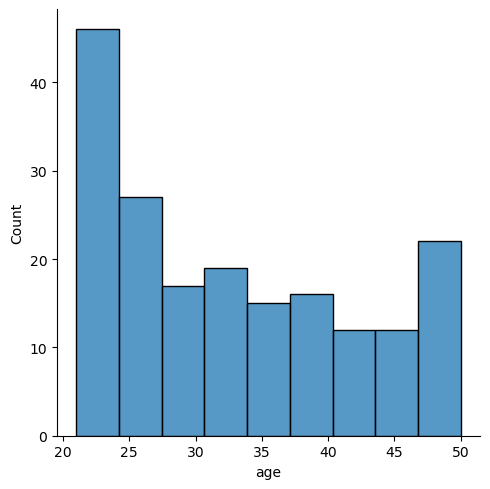

In [8]:
sns.displot(metadata_df[pheno_var])

In [9]:
# use shuffle split

acc, _ = run_ssCV_equaldist(data, metadata_df[pheno_var])
print(f'Mean accuracy (R-squared): {acc:.3f}')



Mean accuracy: 0.211


How can we determine whether this is greater than what would be expected by chance?

In [ ]:
shuf_acc = [acc] # include the actual accuracy to preven p=0
for i in range(500):
    shuf_acc.append(run_ssCV_equaldist(data, metadata_df[pheno_var], 
                                     shuffle_y=True)[0])


In [11]:
pval = np.mean(acc <= np.array(shuf_acc))

print(f'p-value under null: {pval:.3f}')

p-value under null: 0.002


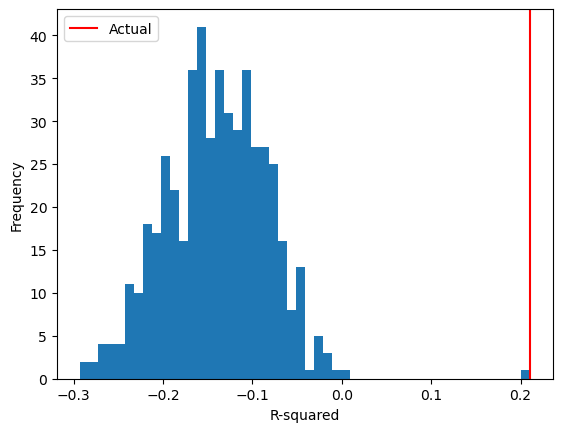

In [12]:
plt.hist(shuf_acc, bins=50)
plt.axvline(acc, color='r')
plt.xlabel('R-squared')
plt.ylabel('Frequency')
plt.legend(['Actual'])